# Brain Tumor Detection (VGG16 Transfer Learning)

## Importing libraries

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
import tensorflow as tf
import os
import random
import shutil
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


In [19]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop



## Data loading- preprocessing and sliting 

In [5]:
source_directory = './data/brain_tumor_dataset'
destination_directory = './data/brainT'

In [6]:
train_ratio = 0.7  # 70% of data for training
val_ratio = 0.15  # 15% of data for validation
test_ratio = 0.15  # 15% of data for testing

In [7]:
train_directory = os.path.join(destination_directory, 'train')
val_directory = os.path.join(destination_directory, 'val')
test_directory = os.path.join(destination_directory, 'test')

os.makedirs(train_directory, exist_ok=True)
os.makedirs(val_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)


In [8]:
for class_name in os.listdir(source_directory):
    class_directory = os.path.join(source_directory, class_name)
    if not os.path.isdir(class_directory):
        continue

    images = os.listdir(class_directory)
    random.shuffle(images)

    train_split = int(len(images) * train_ratio)
    val_split = int(len(images) * (train_ratio + val_ratio))

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    for image in train_images:
        src_path = os.path.join(class_directory, image)
        dst_path = os.path.join(train_directory, class_name, image)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    for image in val_images:
        src_path = os.path.join(class_directory, image)
        dst_path = os.path.join(val_directory, class_name, image)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)

    for image in test_images:
        src_path = os.path.join(class_directory, image)
        dst_path = os.path.join(test_directory, class_name, image)
        os.makedirs(os.path.dirname(dst_path), exist_ok=True)
        shutil.copy(src_path, dst_path)


In [9]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [10]:
# Create an instance of ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    
)

In [11]:
# Generate augmented images from a directory
train_generator = data_generator.flow_from_directory(
    train_directory,
    color_mode='rgb',
    target_size=(100, 100),
    batch_size=32,
    class_mode='binary'
)
# Generate augmented images from a directory
val_generator = data_generator.flow_from_directory(
    val_directory,
    color_mode='rgb',
    target_size=(100, 100),
    batch_size=32,
    class_mode='binary'
)
# Generate augmented images from a directory
test_generator = data_generator.flow_from_directory(
    test_directory,
    color_mode='rgb',
    target_size=(100,100),
    batch_size=32,
    class_mode='binary'
)

Found 220 images belonging to 2 classes.
Found 68 images belonging to 2 classes.
Found 65 images belonging to 2 classes.


## MODEL

### Tranfer model using the VGG16

In [64]:
from tensorflow.keras.applications.vgg16 import VGG16

In [75]:
vgg = VGG16(include_top=False, input_shape=(100, 100, 3))

In [76]:
NUM_CLASSES = 1

vgg16 = Sequential()
vgg16.add(vgg)
vgg16.add(layers.Dropout(0.3))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))
vgg16.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

vgg16.layers[0].trainable = False

vgg16.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)
vgg16.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])

vgg16.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 dropout_15 (Dropout)        (None, 3, 3, 512)         0         
                                                                 
 flatten_10 (Flatten)        (None, 4608)              0         
                                                                 
 dropout_16 (Dropout)        (None, 4608)              0         
                                                                 
 dense_10 (Dense)            (None, 1)                 4609      
                                                                 
Total params: 14,719,297
Trainable params: 4,609
Non-trainable params: 14,714,688
_________________________________________________________________


In [96]:
vgg16_history = vgg16.fit_generator(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
6/6 [==============================] - 12s 2s/step - loss: 1.3013 - accuracy: 0.8011 - val_loss: 1.0136 - val_accuracy: 0.8421
Epoch 2/30
6/6 [==============================] - 11s 2s/step - loss: 2.0291 - accuracy: 0.7841 - val_loss: 2.1701 - val_accuracy: 0.8421
Epoch 3/30
6/6 [==============================] - 12s 2s/step - loss: 1.5601 - accuracy: 0.8239 - val_loss: 0.8612 - val_accuracy: 0.8421
Epoch 4/30
6/6 [==============================] - 10s 2s/step - loss: 1.9731 - accuracy: 0.7614 - val_loss: 1.2659 - val_accuracy: 0.7895
Epoch 5/30
6/6 [==============================] - 11s 2s/step - loss: 1.3904 - accuracy: 0.7955 - val_loss: 1.3157 - val_accuracy: 0.8158
Epoch 6/30
6/6 [==============================] - 12s 2s/step - loss: 1.1957 - accuracy: 0.8523 - val_loss: 1.1718 - val_accuracy: 0.8947
Epoch 7/30
6/6 [==============================] - 12s 2s/step - loss: 1.5575 - accuracy: 0.7841 - val_loss: 1.1362 - val_accuracy: 0.8684
Epoch 8/30
6/6 [==================

In [97]:
# validate on val set
predictions = vgg16.predict(test_generator)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = vgg16.evaluate(val_generator, verbose=0)
_, test_acc = vgg16.evaluate(test_generator, verbose=0)

2/2 [==============================] - 3s 393ms/step


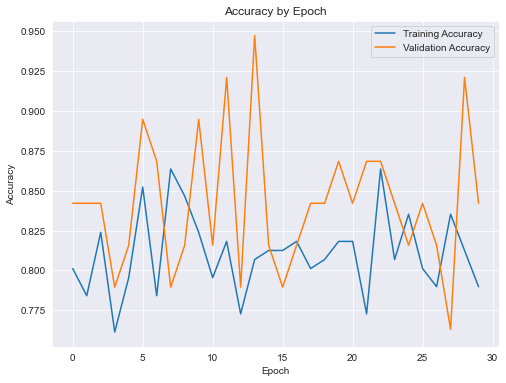

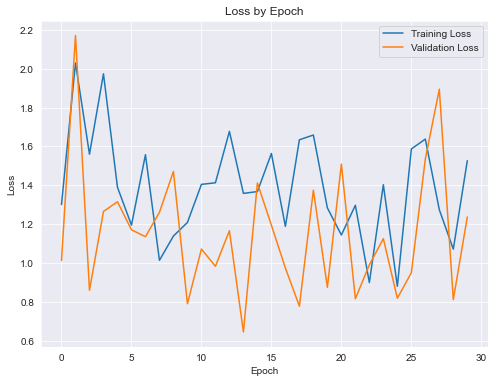

In [98]:
import matplotlib.pyplot as plt

# Get the accuracy and loss values from the history object
accuracy = vgg16_history.history['accuracy']
val_accuracy = vgg16_history.history['val_accuracy']
loss = vgg16_history.history['loss']
val_loss = vgg16_history.history['val_loss']

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


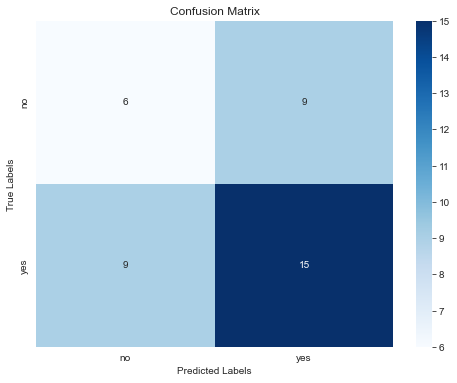

In [99]:
# Convert predictions to binary labels (0 or 1)
predictions = [1 if x > 0.5 else 0 for x in predictions]

# Get the true labels from the test_generator
true_labels = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Get class labels from the test_generator
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()







In [100]:
# Save the entire model
model.save('./model/vgg_bt_model.h5')

# Save only the model weights
model.save_weights('./model/vgg_bt_model_weights.h5')
